source: https://github.com/yusueliu/medium/blob/master/scripts/plot_dirichlet.py

In [22]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import seaborn as sns
from math import gamma
import scipy.special as sc
from scipy.stats import beta, norm
from operator import mul
from functools import reduce
from scipy.stats import dirichlet
sns.set(style='white', font_scale=1.2, font='consolas')

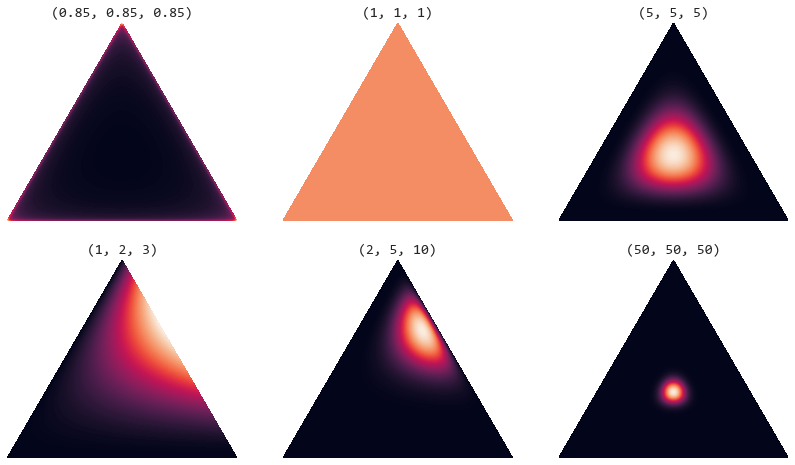

In [2]:
def plot_mesh(corners):
    """Subdivide the triangle into a triangular mesh and plot the original and subdivided triangles."""
    triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=4)
    
    plt.figure(figsize=(6, 4))
    for i, mesh in enumerate((triangle, trimesh)):
        plt.subplot(1, 2, i+1)
        plt.triplot(mesh)
        plt.axis('off')
        plt.axis('equal')    
        
        
class Dirichlet:
    """Define the Dirichlet distribution with vector parameter alpha."""
    def __init__(self, alpha):
        
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / reduce(mul, [gamma(a) for a in self._alpha])
    
    def pdf(self, x):
        """Returns pdf value for `x`. """
        return self._coef * reduce(mul, [xx ** (aa-1) for (xx, aa) in zip(x, self._alpha)])
        
        
class PlotDirichlet:
    """
    Plot the Dirichlet distribution as a contour plot on a 2-Simplex.
    """
    def __init__(self, corners):
        self._corners = corners
        self._triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
        # Midpoints of triangle sides opposite of each corner
        self._midpoints = [(corners[(i+1) % 3] + corners[(i+2) % 3]) / 2.0 for i in range(3)]
        
    def xy2bc(self, xy, tol=1.e-3):
        """Map the x-y coordinates of the mesh vertices to the simplex coordinate space (aka barycentric coordinates).
        Here we use a simple method that uses vector algebra. For some values of alpha, calculation of the Dirichlet pdf 
        can become numerically unstable at the boundaries of the simplex so our conversion function will take an optional 
        tolerance that will avoid barycentric coordinate values directly on the simplex boundary.        
        """
        s = [(self._corners[i] - self._midpoints[i]).dot(xy - self._midpoints[i]) / 0.75 for i in range(3)]
        return np.clip(s, tol, 1.0-tol)
        
    def draw_pdf_contours(self, ax, dist, label=None, nlevels=200, subdiv=8, **kwargs):
        """Draw pdf contours for a Dirichlet distribution"""
        # Subdivide the triangle into a triangular mesh
        refiner = tri.UniformTriRefiner(self._triangle)
        trimesh = refiner.refine_triangulation(subdiv=subdiv)
        
        # convert to barycentric coordinates and compute probabilities of the given distribution 
        pvals = [dist.pdf(self.xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]
    
        ax.tricontourf(trimesh, pvals, nlevels, **kwargs)
        #plt.axis('equal')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 0.75**0.5)
        ax.set_title(str(label))
        ax.axis('off') 
        return ax

        
if __name__ == '__main__':
    corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
    plot_dirichlet = PlotDirichlet(corners)
   
    f, axes = plt.subplots(2, 3, figsize=(14, 8))
    ax = axes[0, 0]
    alpha = (0.85, 0.85, 0.85)
    dist = Dirichlet(alpha)
    ax = plot_dirichlet.draw_pdf_contours(ax, dist, alpha)

    ax = axes[0, 1]
    alpha = (1, 1, 1)
    dist = Dirichlet(alpha)
    ax = plot_dirichlet.draw_pdf_contours(ax, dist, alpha)

    ax = axes[0, 2]
    alpha = (5, 5, 5)
    dist = Dirichlet(alpha)
    ax = plot_dirichlet.draw_pdf_contours(ax, dist, alpha)

    ax = axes[1, 0]
    alpha = (1, 2, 3)
    dist = Dirichlet(alpha)
    ax = plot_dirichlet.draw_pdf_contours(ax, dist, alpha)

    ax = axes[1, 1]
    alpha = (2, 5, 10)
    dist = Dirichlet(alpha)
    ax = plot_dirichlet.draw_pdf_contours(ax, dist, alpha)

    ax = axes[1, 2]
    alpha = (50, 50, 50)
    dist = Dirichlet(alpha)
    ax = plot_dirichlet.draw_pdf_contours(ax, dist, alpha)


## Me messing around

In [3]:
class Dirichlet:
    """Define the Dirichlet distribution with vector parameter alpha."""
    def __init__(self, alpha):
        
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / reduce(mul, [gamma(a) for a in self._alpha])
    
    def pdf(self, x):
        """Returns pdf value for `x`. """
        return self._coef * reduce(mul, [xx ** (aa-1) for (xx, aa) in zip(x, self._alpha)])
        

In [4]:
alpha = [0.4, 5, 15]
dist = Dirichlet(alpha)

In [5]:
dist.pdf([0.2, 0.2, 0.6])

0.28438316849372575

#### more under the hood

In [6]:
_alpha = np.array(alpha)
_coef = gamma(np.sum(_alpha)) / reduce(mul, [gamma(a) for a in _alpha])

In [7]:
x=[0.2, 0.2, 0.6]
_coef * reduce(mul, [xx ** (aa-1) for (xx, aa) in zip(x, _alpha)])

0.28438316849372575

####  compare with scipy

In [8]:
quantiles = np.array([0.2, 0.2, 0.6])  # specify quantiles
alpha = np.array([0.4, 5, 15])  # specify concentration parameters
dirichlet.pdf(quantiles, alpha)

0.2843831684937255

#### calculate myself

In [9]:
reduce(mul, [xx ** (aa-1) for (xx, aa) in zip(x, _alpha)])

3.293210493872053e-06

In [10]:
#calculate second half of the formula, which needs x and alpha
xx=[0.2, 0.2, 0.6]
_alpha=[0.4, 5, 15]
half=1

for x, a in zip(xx, _alpha):
    half*=x**(a-1)

In [11]:
half

3.293210493872053e-06

In [12]:
#calculate normalization factor
1/(np.prod(sc.gamma(_alpha))/sc.gamma(np.sum(_alpha)))

86354.38549187816

In [13]:
_coef

86354.38549187817

## Dirichet process

Source: https://dp.tdhopper.com/dirichlet-distribution/

In [18]:
class DirichletProcessSample():
    def __init__(self, base_measure, alpha):
        self.base_measure = base_measure
        self.alpha = alpha
        
        self.cache = []
        self.weights = []
        self.total_stick_used = 0.

    def __call__(self):
        remaining = 1.0 - self.total_stick_used
        i = DirichletProcessSample.roll_die(self.weights + [remaining])
        if i is not None and i < len(self.weights) :
            return self.cache[i]
        else:
            stick_piece = beta(1, self.alpha).rvs() * remaining
            self.total_stick_used += stick_piece
            self.weights.append(stick_piece)
            new_value = self.base_measure()
            self.cache.append(new_value)
            return new_value
        
    @staticmethod 
    def roll_die(weights):
        if weights:
            return np.random.choice(range(len(weights)), p=weights)
        else:
            return None

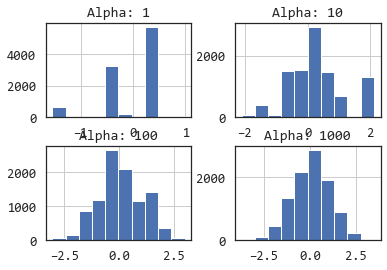

In [24]:
base_measure = lambda: norm().rvs()
n_samples = 10000
samples = {}
for alpha in [1, 10, 100, 1000]:
    dirichlet_norm = DirichletProcessSample(base_measure=base_measure, alpha=alpha)
    samples["Alpha: %s" % alpha] = [dirichlet_norm() for _ in range(n_samples)]

_ = pd.DataFrame(samples).hist()